In [1]:
import pandas as pd
import numpy as np
import logging
import warnings
import time
from IPython.core.interactiveshell import InteractiveShell

import plots
import splitData as sd

# Used to get multiple outputs per cell
InteractiveShell.ast_node_interactivity = "all"

warnings.filterwarnings("ignore")  # ignore warnings in logs

logging.basicConfig(format='%(asctime)s - %(message)s',
                    level=logging.INFO)  # Logging configuration


In [2]:
logging.info('Loading Data Set')
headers = ['userId', 'movieId', 'movie_categoryId',
            'reviewId', 'movieRating', 'reviewDate']
columns = ['userId', 'movieId', 'movie_categoryId', 'movieRating']
data_set = pd.read_csv('../Dataset/movie-ratings.txt',
                           sep=',', names=headers, usecols=columns, dtype={'userId': 'int', 'movieId': 'int', 'movie_categoryId': 'int'})
data_set.shape

2020-05-07 12:37:25,817 - Loading Data Set


(72665, 4)

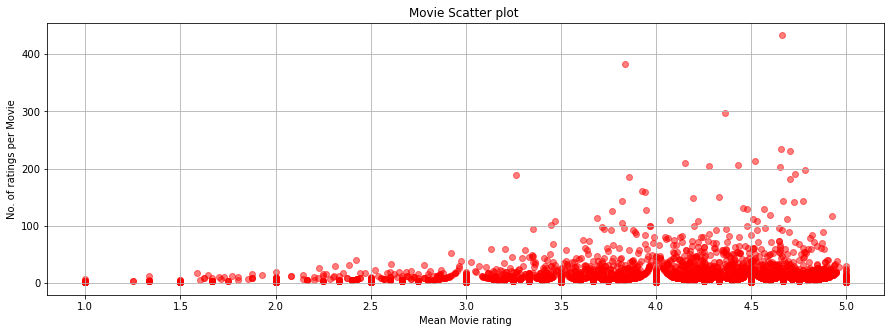

In [3]:
ratings = pd.DataFrame(data_set.groupby('movieId')['movieRating'].mean())
ratings['ratings_per_movie'] = data_set.groupby('movieId')['movieRating'].count()
settings = {'axisX': 'movieRating',
                'axisY': 'ratings_per_movie', 'topic': 'Movie'}
plots.scatterPlot(ratings, settings)
#ratings

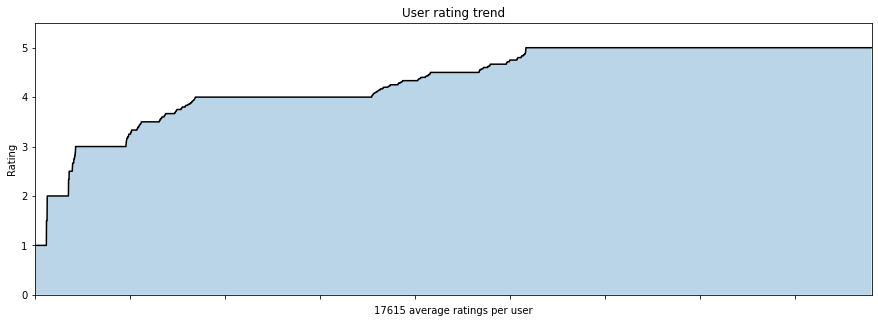

In [4]:
dataset_user_av = data_set.groupby("userId").mean()
# Plot number of movies per rating
plots.avg_ratings_per_user(dataset_user_av['movieRating'])

In [5]:
popular_movie = 50 # threshold to consider a movie popular
unpopular_movies = ratings.loc[ratings['ratings_per_movie'] < popular_movie].index
data_set.drop(data_set.loc[data_set['movieId'].isin(unpopular_movies)].index, inplace=True)
data_set.shape

(16030, 4)

In [6]:
dense_data = data_set.pivot_table(index = 'userId', columns ='movieId', values = 'movieRating')
index_names = dense_data.index
columns_names = dense_data.columns
dense_data = dense_data.values
dense_data.shape

(7632, 179)

In [7]:
train,test = sd.split_train_test(dense_data,0.2)
train.shape
test.shape

(7632, 179)

(7632, 179)

In [8]:
user_avg = np.nanmean(train, axis=1)
user_avg = pd.DataFrame(user_avg, index = index_names)
user_avg.shape

(7632, 1)

In [9]:
start = time.time()
pearson_corr = pd.DataFrame(train.T, columns=index_names).corr()
logging.info("Process done in: {0:.2f} seconds".format(
        time.time() - start))   

2020-05-07 12:37:30,282 - Process done in: 3.81 seconds


In [17]:
k = 5  # Define the k neighbors
qou = int(index_names.shape[0])
neighbors = np.zeros((qou, k)).astype(int)
item=0
start = time.time()
for i in index_names:
    user_corr = pearson_corr[i].drop([i]).sort_values(ascending=False)    
    neighbors[item] = user_corr.iloc[:k].index.values
    item = item + 1
logging.info("Process done in: {0:.2f} seconds".format(
        time.time() - start))
neighbors.shape

2020-05-07 12:38:42,073 - Process done in: 9.12 seconds


(7632, 5)

In [18]:
neighbors = pd.DataFrame(neighbors, index = index_names)
train = pd.DataFrame(train, index = index_names, columns=columns_names)

In [19]:
qom = int(columns_names.shape[0])
item=0
start = time.time()
predicted_matrix = np.empty((qou, qom))
predicted_matrix[:] = np.nan
for user in index_names:
    target_avg = user_avg.at[user,0]
    # target_avg
    k_neigbors = neighbors.loc[user]
    # k_neigbors
    k_correlation = pearson_corr.loc[user, k_neigbors].values
    # k_correlation

    k_ratings = train.loc[k_neigbors,:].values
    # k_ratings

    k_avg = user_avg.loc[k_neigbors].values
    # k_avg


    r_ru = np.subtract(k_ratings,k_avg)
    r_ru_corr = np.multiply(r_ru.T, k_correlation)
    nan_mask = np.isnan(r_ru_corr)
    r_ru_corr = np.ma.masked_array(r_ru_corr, nan_mask)

    numerator = np.sum(r_ru_corr, axis = 1)
    # numerator

    denominator = np.nansum(k_correlation)
    if(denominator > 0):
        predicted_matrix[item] = (numerator/ denominator) + target_avg
    item =  item + 1
logging.info("Process done in: {0:.5f} seconds".format(
        time.time() - start))

2020-05-07 12:38:55,848 - Process done in: 13.75387 seconds


In [20]:
bounds = (1, 5)  # max and min boundaries
predicted_matrix[predicted_matrix < bounds[0]] = 1
predicted_matrix[predicted_matrix > bounds[1]] = 5

In [21]:
pd.DataFrame(predicted_matrix, index=index_names, columns = columns_names)

movieId,23,36,48,53,56,59,62,77,83,85,...,14398,14399,14416,14428,14429,14435,14436,14466,14501,14506
userId,,,,,,,,,,,,,,,,,,,,,
1,4.114286,1.000000,3.952941,3.840000,1.000000,1.000000,4.152941,1.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000
2,3.538889,3.945411,3.619095,3.812573,1.000000,1.000000,4.055556,3.195411,1.0,3.745411,...,4.145411,4.019095,4.055556,3.545411,3.745411,1.0,3.745411,1.0,1.0,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,4.358095,1.000000,1.0,1.000000,1.0,1.0,4.738095
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,4.337363,1.000000,1.0,1.000000,1.0,1.0,1.000000
6,1.000000,1.000000,1.000000,1.000000,4.892063,4.911111,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
logging.info('\nMetric Calculations RMSE')
start = time.time()
I = ~np.isnan(test) # indicator for missing values 
sqerror = abs(test - predicted_matrix) ** 2 # squared error array 
mse = np.nanmean(sqerror[I])  # mean squared error
np.sqrt(mse)
logging.info("Process done in: {0:.5f} seconds".format(
        time.time() - start))

2020-05-07 12:38:55,913 - 
Metric Calculations RMSE


2.6987092892340083

2020-05-07 12:38:55,946 - Process done in: 0.03200 seconds


In [23]:
logging.info('\nMetric Calculations MAE')
start = time.time()
I = ~np.isnan(test) # indicator for missing values 
error = abs(test - predicted_matrix) # error difference array 
np.nanmean(error[I])  # mean squared error
logging.info("Process done in: {0:.5f} seconds".format(
        time.time() - start))

2020-05-07 12:38:55,954 - 
Metric Calculations MAE


2.2703255517430927

2020-05-07 12:38:55,975 - Process done in: 0.02000 seconds
